In [3]:
import sys  
sys.path.insert(0, './scripts')
import MPimports as mpi

In [2]:
import pandas as pd
import numpy as np

In [5]:
chemicals_test = {
    190: "Adenine",
    7504: "phenylmethanamine",
    199: "Agmatine",
    204: "Allantoin",
    227: "anthranilic acid",
    500: "4-Guanidinobutyric acid",
    673: "N,N-dimethylglycine",
    936: "nicotinamide",
    967: "orotic acid",
    1018: "picolinic_acid",
    1102: "spermidine",
    1183: "vanillin",
    5202: "serotonin",
    5350: "sulforaphane",
    5862: "L-cysteine",
    5951: "L-Serine",
    5961: "L-glutamine",
    7618: "triethanolamine",
    62389: "6-Benzylaminopurine",
    68144: "Phenaceturic acid",
    145742: "L-proline",
    637775: "Sinapic acid",
    94214: "Methyl beta-D-galactopyranoside",
    439217: "glucosamine 6-phosphate",
    449093: "trans-Zeatin",
    5280460: "Scopoletin",
    1021: "porphobilinogen",
    1050: "Pyridoxal",
    1701: "AEBSF"
    
}

In [4]:
model = mpi.SequenceDLEnd2end()
model.load_trained()
model.preprocess_data()

Selected device: cuda
Model loaded successfully


In [5]:
mets, prots = model.get_compounds(which="test")

In [7]:
predictions_test = model.predict_pairs(mets, prots, how="cross")

In [8]:
uniprot = pd.read_csv("./data/uniprot_processed.csv", index_col=0)

In [9]:
uniprot = uniprot.set_index("Cross-reference (STRING)")

In [10]:
uniprot_test = uniprot.loc[prots]

In [11]:
family_counts = uniprot.loc[prots]["Protein families"].value_counts()

In [12]:
top_families = family_counts[0:10].index

In [13]:
prots_to_test = uniprot_test[uniprot_test["Protein families"].isin(top_families)].index
chemicals_to_test = np.array(list(chemicals_test.keys()))

In [14]:
preds = model.predict_pairs(chemicals_to_test, prots_to_test, how="cross")

In [15]:
preds_merged = preds.merge(uniprot_test, how = "left", left_on="protein", right_on = "Cross-reference (STRING)")

In [16]:
cross_matrix = preds_merged.replace(chemicals_test).groupby(["Protein families", "chemical"]).mean()["combined_score"].unstack()

In [17]:
cross_matrix

chemical,4-Guanidinobutyric acid,6-Benzylaminopurine,AEBSF,Adenine,Agmatine,Allantoin,L-Serine,L-cysteine,L-glutamine,L-proline,...,orotic acid,phenylmethanamine,picolinic_acid,porphobilinogen,serotonin,spermidine,sulforaphane,trans-Zeatin,triethanolamine,vanillin
Protein families,,,,,,,,,,,,,,,,,,,,,
ATP-dependent AMP-binding enzyme family,0.313934,0.141528,0.208507,0.137777,0.232358,0.169808,0.318407,0.372382,0.158828,0.051167,...,0.271821,0.356197,0.236693,0.234599,0.213405,0.236133,0.046087,0.197983,0.155227,0.614141
Class-I aminoacyl-tRNA synthetase family,0.108621,0.427052,0.393902,0.356885,0.134586,0.031388,0.297209,0.351805,0.293880,0.379968,...,0.153529,0.223267,0.320630,0.212959,0.096041,0.087307,0.160932,0.100138,0.146395,0.204888
Cyclophilin-type PPIase family,0.035485,0.109443,0.083259,0.110874,0.084960,0.023960,0.247949,0.210203,0.056973,0.900706,...,0.042258,0.090647,0.195337,0.051512,0.064064,0.102319,0.127219,0.027116,0.106329,0.028157
"GST superfamily, Tau family",0.017482,0.045902,0.033975,0.002498,0.000185,0.000017,0.001337,0.000339,0.029524,0.000409,...,0.001149,0.008710,0.047736,0.001067,0.000066,0.000088,0.008475,0.000027,0.023158,0.001813
NAD(P)-dependent epimerase/dehydratase family,0.018389,0.084773,0.142613,0.109236,0.128755,0.035167,0.402979,0.180717,0.364143,0.233121,...,0.090278,0.289784,0.187561,0.162261,0.126939,0.187027,0.157871,0.301458,0.203630,0.139184
Peptidase C1 family,0.000720,0.036744,0.539319,0.022137,0.003465,0.001468,0.013097,0.001079,0.000957,0.036310,...,0.001183,0.018702,0.105150,0.024595,0.003876,0.019833,0.165868,0.000612,0.156335,0.028609
Peptidase T1A family,0.127190,0.021092,0.073759,0.022861,0.219907,0.000847,0.999347,0.989582,0.998777,0.994321,...,0.287622,0.017516,0.103790,0.441596,0.004503,0.091105,0.050751,0.000203,0.003086,0.005272
Peptidase T1B family,0.436158,0.102535,0.092222,0.204212,0.320792,0.048770,0.859253,0.769954,0.816478,0.854300,...,0.636763,0.103593,0.288954,0.637029,0.053876,0.183855,0.134905,0.031846,0.078437,0.065943
Short-chain dehydrogenases/reductases (SDR) family,0.025001,0.095107,0.061597,0.038581,0.015966,0.019841,0.343300,0.046930,0.081451,0.088955,...,0.056500,0.159680,0.083976,0.042463,0.064265,0.053430,0.127686,0.152210,0.212814,0.043998


In [18]:
cross_matrix_counts = preds_merged.replace(chemicals_test).groupby(["Protein families", "chemical"])["combined_score"].apply(lambda x: (x > 0.5).sum()).unstack()

In [19]:
from sklearn.cluster import AgglomerativeClustering

In [20]:
clusters = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clusters = clusters.fit(cross_matrix.to_numpy())
clusters.labels_ = cross_matrix.index

In [21]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

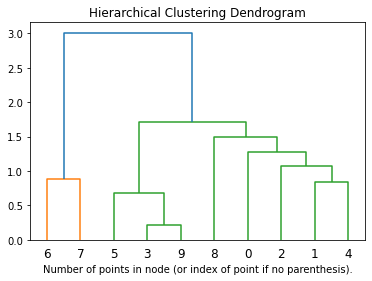

In [22]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clusters, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [23]:
for i in range(10):
    print(i, cross_matrix.index[i])

0 ATP-dependent AMP-binding enzyme family
1 Class-I aminoacyl-tRNA synthetase family
2 Cyclophilin-type PPIase family
3 GST superfamily, Tau family
4 NAD(P)-dependent epimerase/dehydratase family
5 Peptidase C1 family
6 Peptidase T1A family
7 Peptidase T1B family
8 Short-chain dehydrogenases/reductases (SDR) family
9 UDP-glycosyltransferase family


In [24]:
clusters = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clusters = clusters.fit(cross_matrix.to_numpy().T)

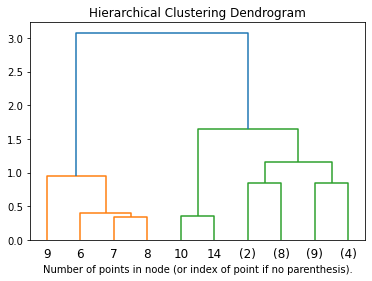

In [25]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clusters, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [29]:
for i in range(29):
    print(i, cross_matrix.columns[i])

0 4-Guanidinobutyric acid
1 6-Benzylaminopurine
2 AEBSF
3 Adenine
4 Agmatine
5 Allantoin
6 L-Serine
7 L-cysteine
8 L-glutamine
9 L-proline
10 Methyl beta-D-galactopyranoside
11 N,N-dimethylglycine
12 Phenaceturic acid
13 Pyridoxal
14 Scopoletin
15 Sinapic acid
16 anthranilic acid
17 glucosamine 6-phosphate
18 nicotinamide
19 orotic acid
20 phenylmethanamine
21 picolinic_acid
22 porphobilinogen
23 serotonin
24 spermidine
25 sulforaphane
26 trans-Zeatin
27 triethanolamine
28 vanillin


In [30]:
clusters = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clusters = clusters.fit((cross_matrix.to_numpy()/np.tile(cross_matrix.sum(axis=0).to_numpy(), [10, 1])).T)

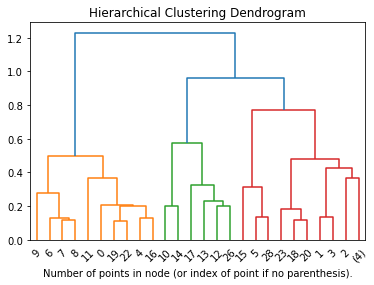

In [32]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clusters, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [33]:
cross_matrix

chemical,4-Guanidinobutyric acid,6-Benzylaminopurine,AEBSF,Adenine,Agmatine,Allantoin,L-Serine,L-cysteine,L-glutamine,L-proline,...,orotic acid,phenylmethanamine,picolinic_acid,porphobilinogen,serotonin,spermidine,sulforaphane,trans-Zeatin,triethanolamine,vanillin
Protein families,,,,,,,,,,,,,,,,,,,,,
ATP-dependent AMP-binding enzyme family,0.313934,0.141528,0.208507,0.137777,0.232358,0.169808,0.318407,0.372382,0.158828,0.051167,...,0.271821,0.356197,0.236693,0.234599,0.213405,0.236133,0.046087,0.197983,0.155227,0.614141
Class-I aminoacyl-tRNA synthetase family,0.108621,0.427052,0.393902,0.356885,0.134586,0.031388,0.297209,0.351805,0.293880,0.379968,...,0.153529,0.223267,0.320630,0.212959,0.096041,0.087307,0.160932,0.100138,0.146395,0.204888
Cyclophilin-type PPIase family,0.035485,0.109443,0.083259,0.110874,0.084960,0.023960,0.247949,0.210203,0.056973,0.900706,...,0.042258,0.090647,0.195337,0.051512,0.064064,0.102319,0.127219,0.027116,0.106329,0.028157
"GST superfamily, Tau family",0.017482,0.045902,0.033975,0.002498,0.000185,0.000017,0.001337,0.000339,0.029524,0.000409,...,0.001149,0.008710,0.047736,0.001067,0.000066,0.000088,0.008475,0.000027,0.023158,0.001813
NAD(P)-dependent epimerase/dehydratase family,0.018389,0.084773,0.142613,0.109236,0.128755,0.035167,0.402979,0.180717,0.364143,0.233121,...,0.090278,0.289784,0.187561,0.162261,0.126939,0.187027,0.157871,0.301458,0.203630,0.139184
Peptidase C1 family,0.000720,0.036744,0.539319,0.022137,0.003465,0.001468,0.013097,0.001079,0.000957,0.036310,...,0.001183,0.018702,0.105150,0.024595,0.003876,0.019833,0.165868,0.000612,0.156335,0.028609
Peptidase T1A family,0.127190,0.021092,0.073759,0.022861,0.219907,0.000847,0.999347,0.989582,0.998777,0.994321,...,0.287622,0.017516,0.103790,0.441596,0.004503,0.091105,0.050751,0.000203,0.003086,0.005272
Peptidase T1B family,0.436158,0.102535,0.092222,0.204212,0.320792,0.048770,0.859253,0.769954,0.816478,0.854300,...,0.636763,0.103593,0.288954,0.637029,0.053876,0.183855,0.134905,0.031846,0.078437,0.065943
Short-chain dehydrogenases/reductases (SDR) family,0.025001,0.095107,0.061597,0.038581,0.015966,0.019841,0.343300,0.046930,0.081451,0.088955,...,0.056500,0.159680,0.083976,0.042463,0.064265,0.053430,0.127686,0.152210,0.212814,0.043998


In [39]:
test_split = pd.concat([model._train_split, model._test_split.drop("Unnamed: 0", axis=1)], axis=0, ignore_index=True)

In [43]:
test_split = model._train_split

In [44]:
train_set = (test_split[test_split["chemical"]
            .isin(chemicals_to_test)]
            .merge(uniprot, how = "left", left_on="protein", right_on = "Cross-reference (STRING)"))

In [45]:
positives_on_set = (train_set[train_set["Protein families"].isin(top_families)]
            .groupby(["Protein families", "chemical"]).count()["protein"].unstack())

In [46]:
positives_on_set.rename(columns = chemicals_test).replace(np.nan, 0)

chemical,anthranilic acid,Pyridoxal,AEBSF,serotonin,L-cysteine,L-Serine,L-glutamine,L-proline,Sinapic acid,Scopoletin
Protein families,,,,,,,,,,
ATP-dependent AMP-binding enzyme family,1.0,0.0,0.0,0.0,34.0,29.0,1.0,1.0,14.0,0.0
Class-I aminoacyl-tRNA synthetase family,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
Cyclophilin-type PPIase family,0.0,0.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0
NAD(P)-dependent epimerase/dehydratase family,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Peptidase C1 family,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Short-chain dehydrogenases/reductases (SDR) family,0.0,17.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
UDP-glycosyltransferase family,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
